<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Facultad de Ciencias Exactas, Naturales y Ambientales</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Entrenamiento de Redes Neuronales
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Andrés Merino &bull; Periodo 2025-02
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

Este notebook está diseñado como una guía práctica para comprender e implementar técnicas de regularización y diferentes optimizadores en redes neuronales. Exploraremos cómo estas técnicas afectan el rendimiento del modelo y previenen el sobreajuste.

### Objetivos de aprendizaje

- Comprender las técnicas de regularización: L1, L2, Dropout y Early Stopping
- Experimentar con diferentes optimizadores: SGD, Adam y RMSProp
- Evaluar el impacto de estas técnicas en el rendimiento del modelo
- Identificar cuándo y cómo aplicar cada técnica

Los paquetes necesarios son:

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [36]:
# Fijar las semillas para reproducibilidad
import random
import os
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

---
## <font color='264CC7'> Parte 1: Conceptos teóricos </font>

### <font color='264CC7'> 1.1 Regularización </font>

La regularización es una técnica fundamental para prevenir el **sobreajuste** (overfitting) en modelos de aprendizaje automático. El sobreajuste ocurre cuando un modelo aprende demasiado bien los datos de entrenamiento, incluyendo el ruido, lo que resulta en un mal rendimiento con datos nuevos.

#### **Regularización L1 (Lasso)**

- Añade una penalización proporcional al **valor absoluto** de los pesos: $\lambda \sum |w_i|$
- Tiende a producir **modelos dispersos** (muchos pesos se vuelven exactamente cero)
- Útil para **selección de características**: elimina características irrelevantes
- Parámetro de regularización: `kernel_regularizer=l1(0.01)`

#### **Regularización L2 (Ridge)**

- Añade una penalización proporcional al **cuadrado** de los pesos: $\lambda \sum w_i^2$
- Distribuye el castigo de manera más uniforme
- Reduce los pesos pero raramente los lleva a cero
- Más común en redes neuronales profundas
- Parámetro de regularización: `kernel_regularizer=l2(0.01)`

#### **Dropout**

- Durante el entrenamiento, **desactiva aleatoriamente** un porcentaje de neuronas
- Previene que la red dependa demasiado de neuronas específicas
- Crea un efecto de "ensemble" interno
- Típicamente se usa entre 0.2 (20%) y 0.5 (50%) de dropout
- Se aplica como una capa: `Dropout(0.3)`

#### **Early Stopping**

- Detiene el entrenamiento cuando el rendimiento en validación deja de mejorar
- Previene el sobreajuste sin modificar la arquitectura del modelo
- Requiere dividir los datos en conjuntos de entrenamiento y validación
- Parámetros importantes:
  - `monitor='val_loss'`: métrica a observar
  - `patience=10`: épocas sin mejora antes de detener
  - `restore_best_weights=True`: restaurar los mejores pesos

### <font color='264CC7'> 1.2 Optimizadores </font>

Los optimizadores determinan **cómo se actualizan los pesos** durante el entrenamiento.

#### **SGD (Stochastic Gradient Descent)**

- El optimizador más básico
- Actualiza los pesos en dirección opuesta al gradiente
- Fórmula: $w = w - \eta \nabla L$, donde $\eta$ es la tasa de aprendizaje
- Ventajas: Simple, predecible, funciona bien con momentum
- Desventajas: Puede ser lento, sensible a la tasa de aprendizaje
- Uso: `SGD(learning_rate=0.01, momentum=0.9)`

#### **Adam (Adaptive Moment Estimation)**

- Combina las ideas de momentum y RMSProp
- Adapta la tasa de aprendizaje para cada parámetro
- Mantiene promedios móviles del gradiente y su cuadrado
- Ventajas: Muy eficiente, requiere poca sintonización, converge rápido
- Desventajas: Puede no generalizar tan bien como SGD en algunos casos
- Uso: `Adam(learning_rate=0.001)` (tasa de aprendizaje por defecto)

#### **RMSProp (Root Mean Square Propagation)**

- Adapta la tasa de aprendizaje dividiendo por un promedio móvil de los gradientes recientes
- Especialmente útil para problemas con gradientes ruidosos
- Funciona bien en problemas no estacionarios
- Ventajas: Bueno para RNNs, maneja bien gradientes ruidosos
- Uso: `RMSprop(learning_rate=0.001)`

#### **Comparación rápida**

- **SGD**: Usa cuando tengas mucho tiempo y datos, o cuando la generalización sea crítica
- **Adam**: La opción por defecto, excelente punto de partida
- **RMSProp**: Bueno para problemas recurrentes o cuando Adam no funciona bien

---
## <font color='264CC7'> Parte 2: Preparación de datos </font>

Utilizaremos el mismo dataset de Pokémon para experimentar con diferentes técnicas:

In [37]:
# Leer los datos
data = pd.read_csv('https://raw.githubusercontent.com/andres-merino/AprendizajeAutomaticoInicial-05-N0105/refs/heads/main/2-Notebooks/datos/Pokemon.csv')

# Seleccionar columnas de interés
numeric_cols = ['Attack', 'Defense', 'Speed', 'Sp. Atk', 'Sp. Def', 'HP']
class_col = ['Stage']
data = data[['Name', *numeric_cols, *class_col]]

# Mostrar información básica
print(f"Total de registros: {len(data)}")
print(f"\nDistribución de clases:")
print(data['Stage'].value_counts())
display(data.head())

Total de registros: 151

Distribución de clases:
Stage
0    81
1    54
2    16
Name: count, dtype: int64


,Name,Attack,Defense,Speed,Sp. Atk,Sp. Def,HP,Stage
0,Bulbasaur,49,49,45,65,65,45,2
1,Ivysaur,62,63,60,80,80,60,1
2,Venusaur,82,83,80,100,100,80,0
3,Charmander,52,43,65,60,50,39,2
4,Charmeleon,64,58,80,80,65,58,1


In [38]:
# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(data[numeric_cols])

# Codificar las clases a formato one-hot
y_one_hot = to_categorical(data['Stage'])

print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y_one_hot.shape}")

Forma de X: (151, 6)
Forma de y: (151, 3)


In [39]:
# Dividir en entrenamiento, validación y prueba
# Primero: 60% entrenamiento, 40% temporal
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_one_hot, test_size=0.4, random_state=42, stratify=data['Stage']
)

# Segundo: dividir el 40% temporal en 20% validación y 20% prueba
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de validación: {X_val.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

Conjunto de entrenamiento: 90 muestras
Conjunto de validación: 30 muestras
Conjunto de prueba: 31 muestras


---
## <font color='264CC7'> Parte 3: Experimentación con Regularización </font>

### <font color='264CC7'> 3.1 Modelo sin regularización (baseline) </font>

In [40]:
# Crear modelo sin regularización
set_seed(42)

model_baseline = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model_baseline.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

model_baseline.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 64)                448       
                                                                 
 dense_52 (Dense)            (None, 32)                2080      
                                                                 
 dense_53 (Dense)            (None, 16)                528       
                                                                 
 dense_54 (Dense)            (None, 3)                 51        
                                                                 
Total params: 3,107
Trainable params: 3,107
Non-trainable params: 0
_________________________________________________________________


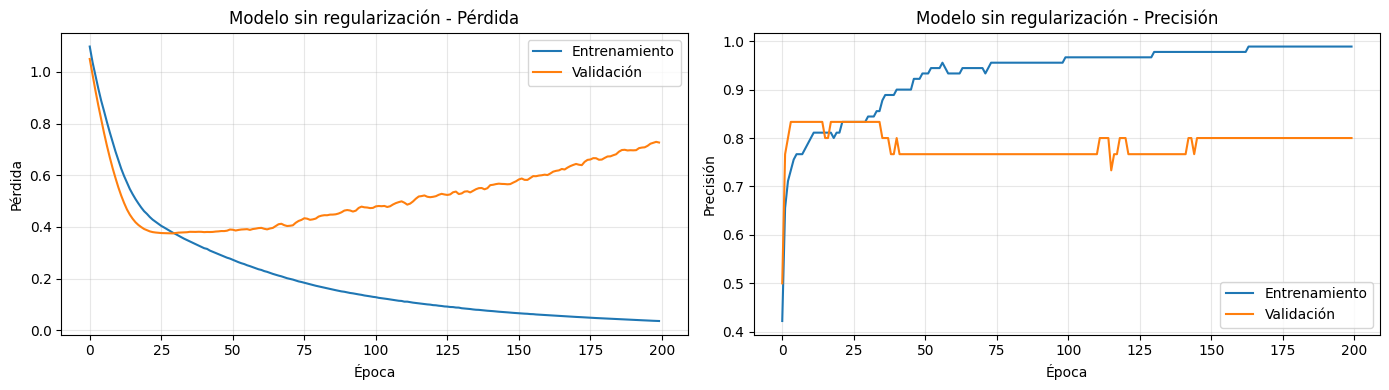


Precisión final en entrenamiento: 0.9889
Precisión final en validación: 0.8000


In [41]:
# Entrenar el modelo baseline
history_baseline = model_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=0
)

# Visualizar el entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Pérdida
ax1.plot(history_baseline.history['loss'], label='Entrenamiento')
ax1.plot(history_baseline.history['val_loss'], label='Validación')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.set_title('Modelo sin regularización - Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precisión
ax2.plot(history_baseline.history['accuracy'], label='Entrenamiento')
ax2.plot(history_baseline.history['val_accuracy'], label='Validación')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.set_title('Modelo sin regularización - Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrecisión final en entrenamiento: {history_baseline.history['accuracy'][-1]:.4f}")
print(f"Precisión final en validación: {history_baseline.history['val_accuracy'][-1]:.4f}")

### <font color='264CC7'> 3.2 Modelo con regularización L2 </font>

In [42]:
# Crear modelo con regularización L2
set_seed(42)

model_l2 = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(3, activation='softmax')
])

model_l2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Modelo con regularización L2 creado")

Modelo con regularización L2 creado


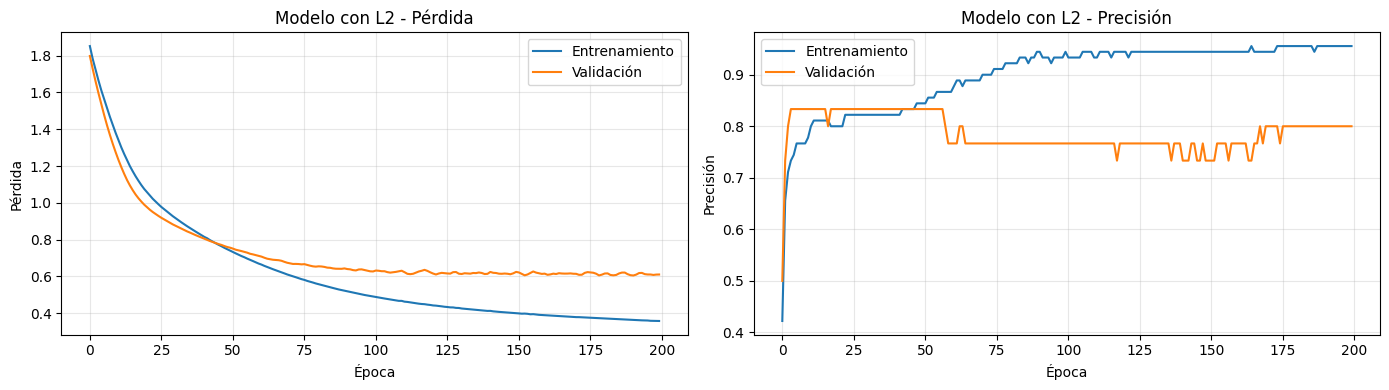


Precisión final en entrenamiento: 0.9556
Precisión final en validación: 0.8000


In [43]:
# Entrenar el modelo con L2
history_l2 = model_l2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=0
)

# Visualizar el entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Pérdida
ax1.plot(history_l2.history['loss'], label='Entrenamiento')
ax1.plot(history_l2.history['val_loss'], label='Validación')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.set_title('Modelo con L2 - Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precisión
ax2.plot(history_l2.history['accuracy'], label='Entrenamiento')
ax2.plot(history_l2.history['val_accuracy'], label='Validación')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.set_title('Modelo con L2 - Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrecisión final en entrenamiento: {history_l2.history['accuracy'][-1]:.4f}")
print(f"Precisión final en validación: {history_l2.history['val_accuracy'][-1]:.4f}")

### <font color='264CC7'> 3.3 Modelo con Dropout </font>

In [44]:
# Crear modelo con Dropout
set_seed(42)

model_dropout = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_dropout.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Modelo con Dropout creado")

Modelo con Dropout creado


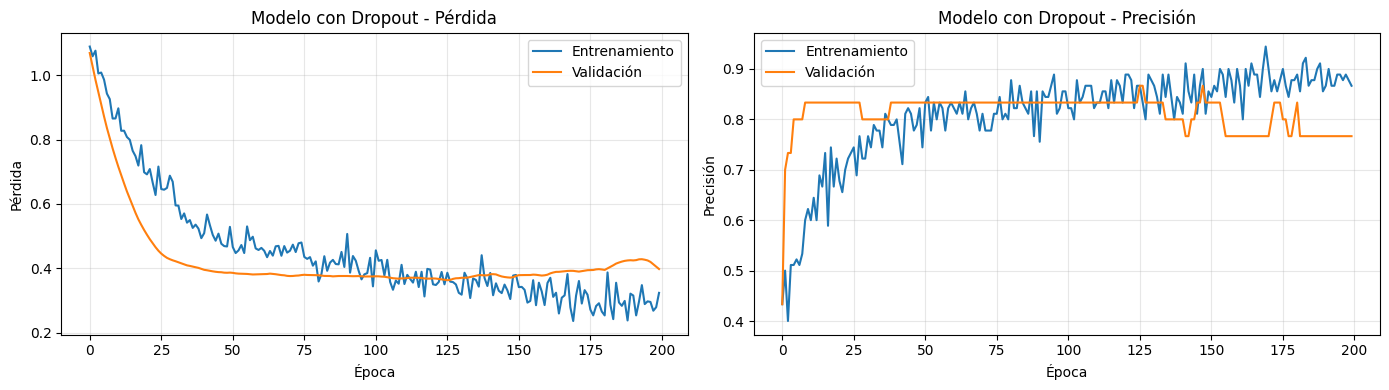


Precisión final en entrenamiento: 0.8667
Precisión final en validación: 0.7667


In [45]:
# Entrenar el modelo con Dropout
history_dropout = model_dropout.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=0
)

# Visualizar el entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Pérdida
ax1.plot(history_dropout.history['loss'], label='Entrenamiento')
ax1.plot(history_dropout.history['val_loss'], label='Validación')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.set_title('Modelo con Dropout - Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precisión
ax2.plot(history_dropout.history['accuracy'], label='Entrenamiento')
ax2.plot(history_dropout.history['val_accuracy'], label='Validación')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.set_title('Modelo con Dropout - Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrecisión final en entrenamiento: {history_dropout.history['accuracy'][-1]:.4f}")
print(f"Precisión final en validación: {history_dropout.history['val_accuracy'][-1]:.4f}")

### <font color='264CC7'> 3.4 Modelo con Early Stopping </font>

In [46]:
# Crear modelo con Early Stopping
set_seed(42)

model_early = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model_early.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Definir callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

print("Modelo con Early Stopping creado")

Modelo con Early Stopping creado


Restoring model weights from the end of the best epoch: 30.
Epoch 50: early stopping


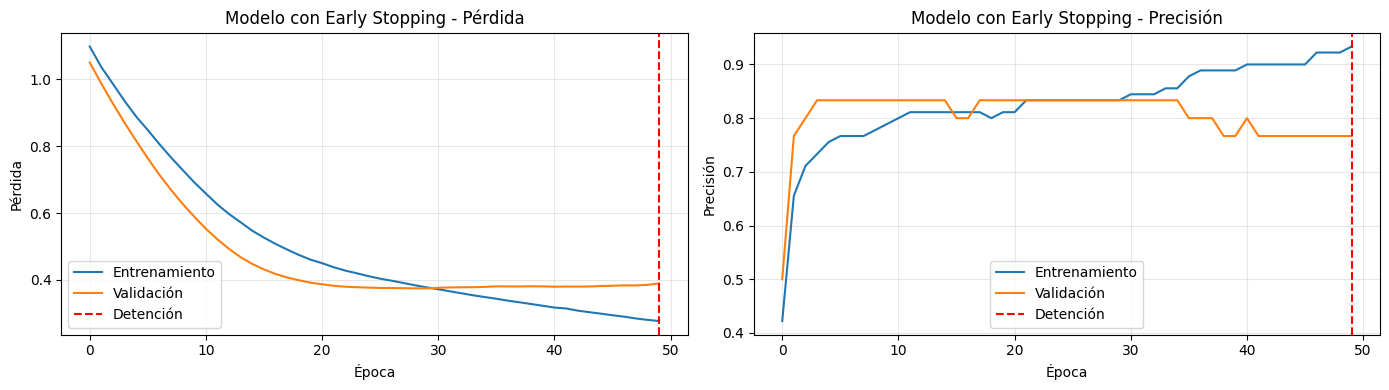


Entrenamiento detenido en época: 50
Precisión final en entrenamiento: 0.9333
Precisión final en validación: 0.7667


In [47]:
# Entrenar el modelo con Early Stopping
history_early = model_early.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

# Visualizar el entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Pérdida
ax1.plot(history_early.history['loss'], label='Entrenamiento')
ax1.plot(history_early.history['val_loss'], label='Validación')
ax1.axvline(x=len(history_early.history['loss'])-1, color='red', linestyle='--', label='Detención')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.set_title('Modelo con Early Stopping - Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precisión
ax2.plot(history_early.history['accuracy'], label='Entrenamiento')
ax2.plot(history_early.history['val_accuracy'], label='Validación')
ax2.axvline(x=len(history_early.history['accuracy'])-1, color='red', linestyle='--', label='Detención')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.set_title('Modelo con Early Stopping - Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEntrenamiento detenido en época: {len(history_early.history['loss'])}")
print(f"Precisión final en entrenamiento: {history_early.history['accuracy'][-1]:.4f}")
print(f"Precisión final en validación: {history_early.history['val_accuracy'][-1]:.4f}")

### <font color='264CC7'> 3.5 Comparación de técnicas de regularización </font>

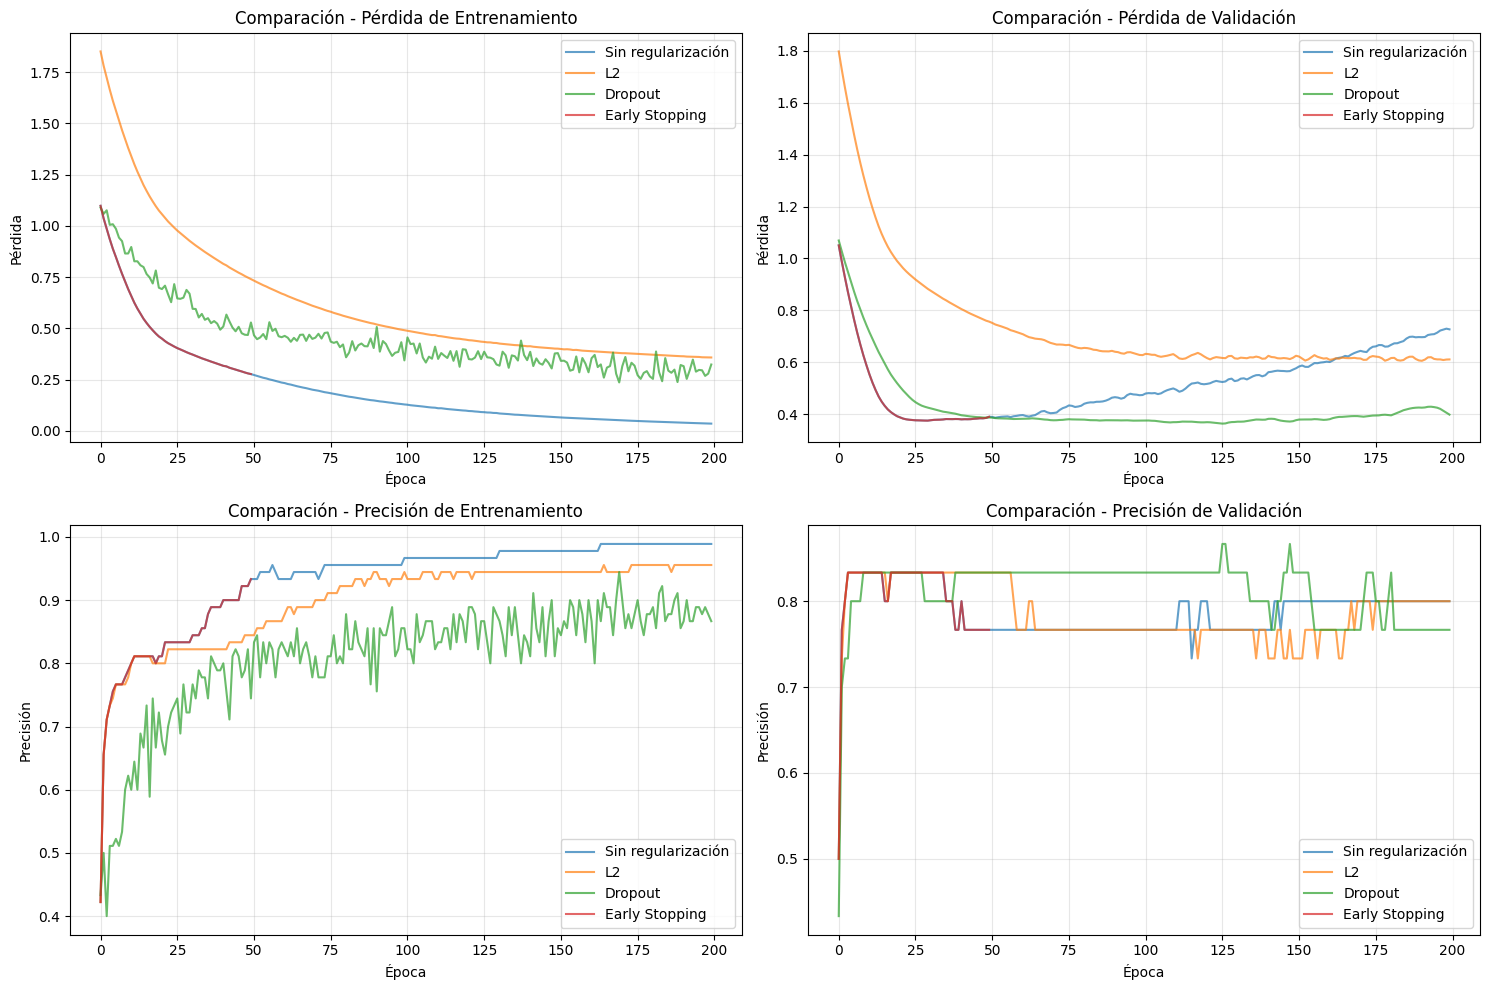

In [48]:
# Comparar todas las técnicas de regularización
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Pérdida de entrenamiento
ax1.plot(history_baseline.history['loss'], label='Sin regularización', alpha=0.7)
ax1.plot(history_l2.history['loss'], label='L2', alpha=0.7)
ax1.plot(history_dropout.history['loss'], label='Dropout', alpha=0.7)
ax1.plot(history_early.history['loss'], label='Early Stopping', alpha=0.7)
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.set_title('Comparación - Pérdida de Entrenamiento')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Pérdida de validación
ax2.plot(history_baseline.history['val_loss'], label='Sin regularización', alpha=0.7)
ax2.plot(history_l2.history['val_loss'], label='L2', alpha=0.7)
ax2.plot(history_dropout.history['val_loss'], label='Dropout', alpha=0.7)
ax2.plot(history_early.history['val_loss'], label='Early Stopping', alpha=0.7)
ax2.set_xlabel('Época')
ax2.set_ylabel('Pérdida')
ax2.set_title('Comparación - Pérdida de Validación')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Precisión de entrenamiento
ax3.plot(history_baseline.history['accuracy'], label='Sin regularización', alpha=0.7)
ax3.plot(history_l2.history['accuracy'], label='L2', alpha=0.7)
ax3.plot(history_dropout.history['accuracy'], label='Dropout', alpha=0.7)
ax3.plot(history_early.history['accuracy'], label='Early Stopping', alpha=0.7)
ax3.set_xlabel('Época')
ax3.set_ylabel('Precisión')
ax3.set_title('Comparación - Precisión de Entrenamiento')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Precisión de validación
ax4.plot(history_baseline.history['val_accuracy'], label='Sin regularización', alpha=0.7)
ax4.plot(history_l2.history['val_accuracy'], label='L2', alpha=0.7)
ax4.plot(history_dropout.history['val_accuracy'], label='Dropout', alpha=0.7)
ax4.plot(history_early.history['val_accuracy'], label='Early Stopping', alpha=0.7)
ax4.set_xlabel('Época')
ax4.set_ylabel('Precisión')
ax4.set_title('Comparación - Precisión de Validación')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
# Evaluar todos los modelos en el conjunto de prueba
modelos = {
    'Sin regularización': model_baseline,
    'Regularización L2': model_l2,
    'Dropout': model_dropout,
    'Early Stopping': model_early
}

print("\n" + "="*60)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*60)

resultados = []
for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    resultados.append({'Modelo': nombre, 'Precisión': accuracy})
    
    print(f"\n{nombre}:")
    print(f"  Precisión: {accuracy:.4f}")

# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados)
print("\n" + "="*60)
print(df_resultados.to_string(index=False))


EVALUACIÓN EN CONJUNTO DE PRUEBA

Sin regularización:
  Precisión: 0.7742

Regularización L2:
  Precisión: 0.7742

Dropout:
  Precisión: 0.8065

Early Stopping:
  Precisión: 0.8387

            Modelo  Precisión
Sin regularización   0.774194
 Regularización L2   0.774194
           Dropout   0.806452
    Early Stopping   0.838710


---
## <font color='264CC7'> Parte 4: Experimentación con Optimizadores </font>

### <font color='264CC7'> 4.1 Modelo con SGD </font>

In [50]:
# Crear y entrenar modelo con SGD
set_seed(42)

model_sgd = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

# SGD con momentum
optimizer_sgd = SGD(learning_rate=0.01, momentum=0.9)
model_sgd.compile(
    optimizer=optimizer_sgd,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

history_sgd = model_sgd.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=0
)

print("Modelo con SGD entrenado")

Modelo con SGD entrenado


### <font color='264CC7'> 4.2 Modelo con Adam </font>

In [51]:
# Crear y entrenar modelo con Adam
set_seed(42)

model_adam = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

optimizer_adam = Adam(learning_rate=0.001)
model_adam.compile(
    optimizer=optimizer_adam,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

history_adam = model_adam.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=0
)

print("Modelo con Adam entrenado")

Modelo con Adam entrenado


### <font color='264CC7'> 4.3 Modelo con RMSProp </font>

In [52]:
# Crear y entrenar modelo con RMSProp
set_seed(42)

model_rmsprop = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

optimizer_rmsprop = RMSprop(learning_rate=0.001)
model_rmsprop.compile(
    optimizer=optimizer_rmsprop,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

history_rmsprop = model_rmsprop.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=0
)

print("Modelo con RMSProp entrenado")

Modelo con RMSProp entrenado


### <font color='264CC7'> 4.4 Comparación de optimizadores </font>

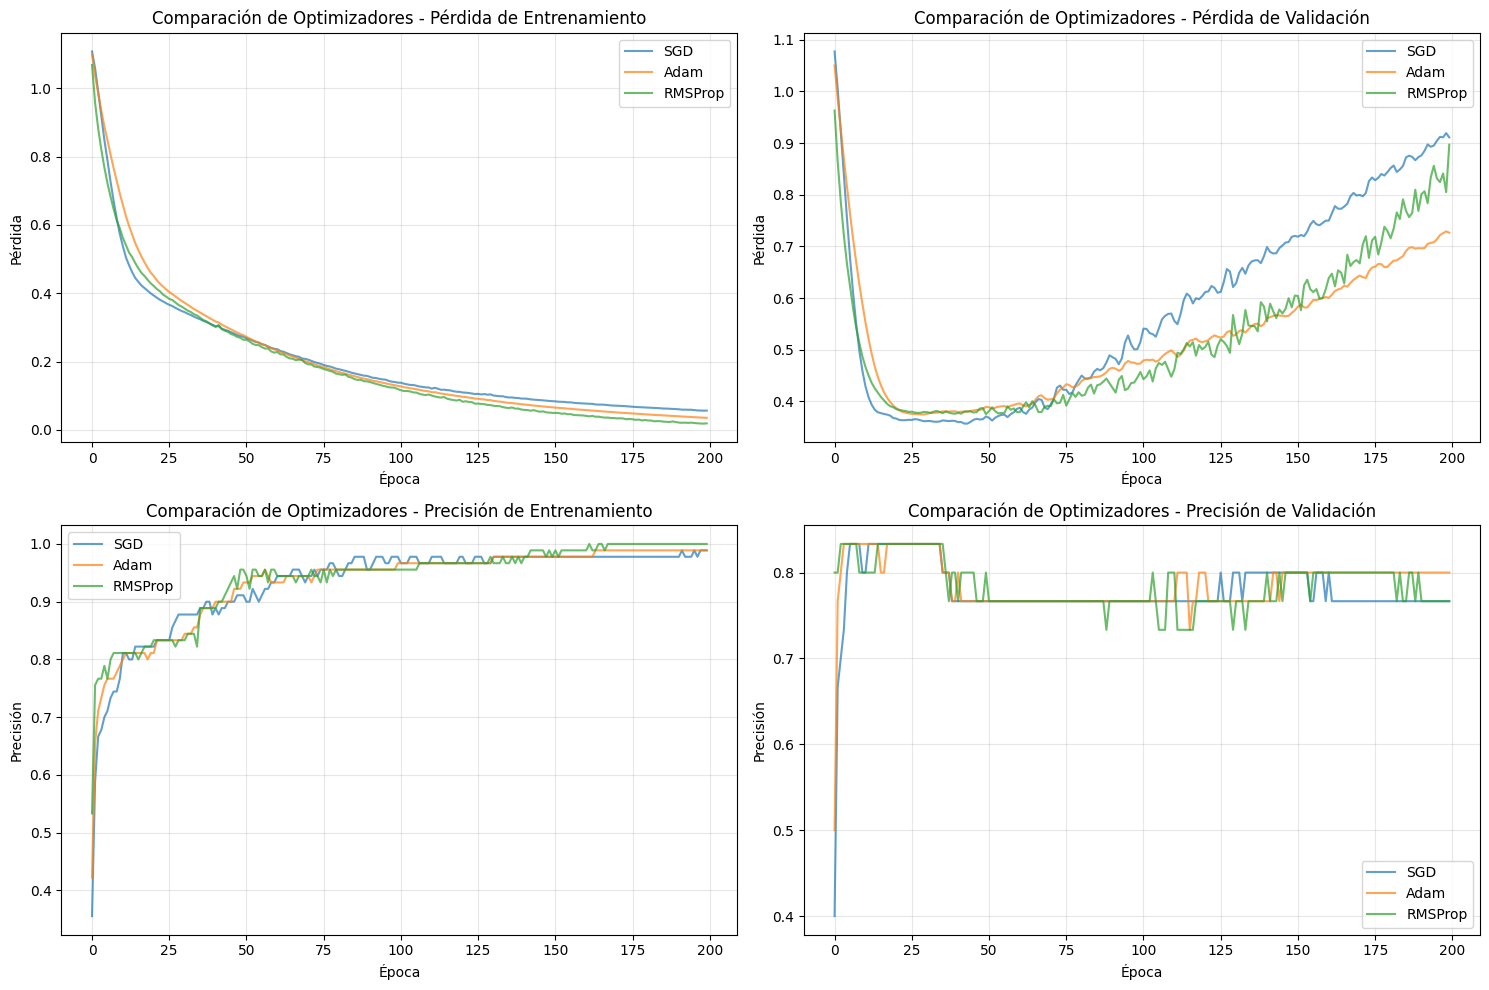

In [53]:
# Comparar todos los optimizadores
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Pérdida de entrenamiento
ax1.plot(history_sgd.history['loss'], label='SGD', alpha=0.7)
ax1.plot(history_adam.history['loss'], label='Adam', alpha=0.7)
ax1.plot(history_rmsprop.history['loss'], label='RMSProp', alpha=0.7)
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.set_title('Comparación de Optimizadores - Pérdida de Entrenamiento')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Pérdida de validación
ax2.plot(history_sgd.history['val_loss'], label='SGD', alpha=0.7)
ax2.plot(history_adam.history['val_loss'], label='Adam', alpha=0.7)
ax2.plot(history_rmsprop.history['val_loss'], label='RMSProp', alpha=0.7)
ax2.set_xlabel('Época')
ax2.set_ylabel('Pérdida')
ax2.set_title('Comparación de Optimizadores - Pérdida de Validación')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Precisión de entrenamiento
ax3.plot(history_sgd.history['accuracy'], label='SGD', alpha=0.7)
ax3.plot(history_adam.history['accuracy'], label='Adam', alpha=0.7)
ax3.plot(history_rmsprop.history['accuracy'], label='RMSProp', alpha=0.7)
ax3.set_xlabel('Época')
ax3.set_ylabel('Precisión')
ax3.set_title('Comparación de Optimizadores - Precisión de Entrenamiento')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Precisión de validación
ax4.plot(history_sgd.history['val_accuracy'], label='SGD', alpha=0.7)
ax4.plot(history_adam.history['val_accuracy'], label='Adam', alpha=0.7)
ax4.plot(history_rmsprop.history['val_accuracy'], label='RMSProp', alpha=0.7)
ax4.set_xlabel('Época')
ax4.set_ylabel('Precisión')
ax4.set_title('Comparación de Optimizadores - Precisión de Validación')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
# Evaluar todos los optimizadores en el conjunto de prueba
optimizadores = {
    'SGD': model_sgd,
    'Adam': model_adam,
    'RMSProp': model_rmsprop
}

print("\n" + "="*60)
print("COMPARACIÓN DE OPTIMIZADORES - CONJUNTO DE PRUEBA")
print("="*60)

resultados_opt = []
for nombre, modelo in optimizadores.items():
    y_pred = modelo.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    resultados_opt.append({'Optimizador': nombre, 'Precisión': accuracy})
    
    print(f"\n{nombre}:")
    print(f"  Precisión: {accuracy:.4f}")

# Crear DataFrame con resultados
df_resultados_opt = pd.DataFrame(resultados_opt)
print("\n" + "="*60)
print(df_resultados_opt.to_string(index=False))


COMPARACIÓN DE OPTIMIZADORES - CONJUNTO DE PRUEBA

SGD:
  Precisión: 0.7742

Adam:
  Precisión: 0.7742

RMSProp:
  Precisión: 0.7419

Optimizador  Precisión
        SGD   0.774194
       Adam   0.774194
    RMSProp   0.741935
